<a href="https://colab.research.google.com/github/tejaspradhan/Graph-Neural-Networks/blob/main/hiv-project/ensemble_gnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@title
# Install rdkit
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO
 
 
logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)
 
 
def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """
 
    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )
 
    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)
 
    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return
 
        logger.info("force re-install")
 
    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)
 
    logger.info("python version: {}".format(python_version))
 
    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)
 
    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')
 
    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')
 
    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python==3.7.3",
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")
 
    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))
 
 
if __name__ == "__main__":
    install()

add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
python version: 3.7.12
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit
done
rdkit-2020.09.1 installation finished!


In [3]:
! pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
! pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
! pip install -q torch-cluster -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
! pip install -q torch-geometric

     |████████████████████████████████| 7.9 MB 2.4 MB/s 
     |████████████████████████████████| 3.5 MB 2.1 MB/s 
     |████████████████████████████████| 2.3 MB 2.1 MB/s 
     |████████████████████████████████| 370 kB 3.3 MB/s 
     |████████████████████████████████| 482 kB 59.3 MB/s 
     |████████████████████████████████| 41 kB 624 kB/s 


In [28]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch 
import torch.nn.functional as F 
import torch_geometric
from torch_geometric.data import Dataset, Data
from torch_geometric.nn import GATConv, Linear, TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.loader import DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
from torch_geometric.nn import GCNConv
from sklearn import metrics

In [5]:
class HIVDataset(Dataset):
    def __init__(self, root, filename, test=False, transform=None, pre_transform=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data). 
        """
        self.test = test
        self.filename = filename
        super(HIVDataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)  
        """
        return self.filename

    @property
    def processed_file_names(self):
        return 'not_implemented.pt'

    def download(self):
        pass

    def process(self):
        self.data = pd.read_csv(self.raw_paths[0])
        print(self.raw_paths)
        for index, mol in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            mol_obj = Chem.MolFromSmiles(mol["smiles"])
            # Get node features
            node_feats = self._get_node_features(mol_obj)
            # Get edge features
            edge_feats = self._get_edge_features(mol_obj)
            # Get adjacency info
            edge_index = self._get_adjacency_info(mol_obj)
            # Get labels info
            label = self._get_labels(mol["HIV_active"])

            # Create data object
            data = Data(x=node_feats, 
                        edge_index=edge_index,
                        edge_attr=edge_feats,
                        y=label,
                        smiles=mol["smiles"]
                        ) 
            if self.test:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_test_{index}.pt'))
            else:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_{index}.pt'))

    def _get_node_features(self, mol):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of Nodes, Node Feature size]
        """
        all_node_feats = []

        for atom in mol.GetAtoms():
            node_feats = []
            # Feature 1: Atomic number        
            node_feats.append(atom.GetAtomicNum())
            # Feature 2: Atom degree
            node_feats.append(atom.GetDegree())
            # Feature 3: Formal charge
            node_feats.append(atom.GetFormalCharge())
            # Feature 4: Hybridization
            node_feats.append(atom.GetHybridization())
            # Feature 5: Aromaticity
            node_feats.append(atom.GetIsAromatic())
            # Feature 6: Total Num Hs
            node_feats.append(atom.GetTotalNumHs())
            # Feature 7: Radical Electrons
            node_feats.append(atom.GetNumRadicalElectrons())
            # Feature 8: In Ring
            node_feats.append(atom.IsInRing())
            # Feature 9: Chirality
            node_feats.append(atom.GetChiralTag())

            # Append node features to matrix
            all_node_feats.append(node_feats)

        all_node_feats = np.asarray(all_node_feats)
        return torch.tensor(all_node_feats, dtype=torch.float)

    def _get_edge_features(self, mol):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of edges, Edge Feature size]
        """
        all_edge_feats = []

        for bond in mol.GetBonds():
            edge_feats = []
            # Feature 1: Bond type (as double)
            edge_feats.append(bond.GetBondTypeAsDouble())
            # Feature 2: Rings
            edge_feats.append(bond.IsInRing())
            # Append node features to matrix (twice, per direction)
            all_edge_feats += [edge_feats, edge_feats]

        all_edge_feats = np.asarray(all_edge_feats)
        return torch.tensor(all_edge_feats, dtype=torch.float)

    def _get_adjacency_info(self, mol):
        """
        We could also use rdmolops.GetAdjacencyMatrix(mol)
        but we want to be sure that the order of the indices
        matches the order of the edge features
        """
        edge_indices = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edge_indices += [[i, j], [j, i]]

        edge_indices = torch.tensor(edge_indices)
        edge_indices = edge_indices.t().to(torch.long).view(2, -1)
        return edge_indices

    def _get_labels(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.data.shape[0]

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{idx}.pt'))   
        return data

In [9]:
train_dataset = HIVDataset(root='data/',filename='HIV_train_oversampled.csv')
test_dataset = HIVDataset(root='data/',filename='HIV_test.csv')

Processing...


['data/raw/HIV_test.csv']


100%|██████████| 3999/3999 [00:11<00:00, 345.54it/s]
Done!


In [10]:
class GCN(torch.nn.Module):
    def __init__(self, feature_size, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        num_classes = 2
        self.conv1 = GCNConv(feature_size, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = gap(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [11]:
class GNN(torch.nn.Module):
  def __init__(self,feature_size):
    super(GNN, self).__init__()
    num_classes=1
    embedding_size=1024
    self.conv1 = GATConv(feature_size,embedding_size, heads=3, dropout =0.3)
    self.head_transform1 = Linear(embedding_size*3, embedding_size)
    self.pool1 = TopKPooling(embedding_size,ratio=0.8)

    self.conv2 = GATConv(embedding_size, embedding_size, heads=3, dropout =0.3)
    self.head_transform2 = Linear(embedding_size*3, embedding_size)
    self.pool2 = TopKPooling(embedding_size,ratio=0.5)

    self.conv3 = GATConv(embedding_size, embedding_size, heads=3, dropout =0.3)
    self.head_transform3 = Linear(embedding_size*3, embedding_size)
    self.pool3 = TopKPooling(embedding_size,ratio=0.2)

    self.linear1 = Linear(embedding_size*2,1024)
    self.linear2 = Linear(1024,num_classes)

  def forward(self, x, edge_attr,edge_index,batch_index):
    x = self.conv1(x,edge_index)
    x = self.head_transform1(x)

    x,edge_index,edge_attr,batch_index, _ , _ = self.pool1(x,edge_index,None, batch_index)

    x1 = torch.cat([gmp(x,batch_index),gap(x,batch_index)],dim=1)

    x = self.conv2(x,edge_index)
    x = self.head_transform2(x)

    x,edge_index,edge_attr,batch_index, _ , _ = self.pool2(x,edge_index,None, batch_index)

    x2 = torch.cat([gmp(x,batch_index),gap(x,batch_index)],dim=1)

    x = self.conv3(x,edge_index)
    x = self.head_transform3(x)

    x,edge_index,edge_attr,batch_index, _ , _ = self.pool3(x,edge_index,None, batch_index)

    x3 = torch.cat([gmp(x,batch_index),gap(x,batch_index)],dim=1)

    x=x1+x2+x3

    x = self.linear1(x).relu()
    x = F.dropout(x,p=0.5, training=self.training) 
    x = self.linear2(x)

    return x

In [15]:
gcn_model = GCN(test_dataset[0].x.shape[1], 256)

In [16]:
gat_model = GNN(test_dataset[0].x.shape[1])

In [17]:
gat_model.load_state_dict(torch.load('/content/drive/MyDrive/GNN_HIV/models/model-hiv-60epochs.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

In [18]:
gcn_model.load_state_dict(torch.load('/content/drive/MyDrive/GNN_HIV/models/gcn/model-hiv-500epochs.pt',map_location = torch.device('cpu')))

<All keys matched successfully>

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
gat_model.to(device)
gcn_model.to(device)

GCN(
  (conv1): GCNConv(9, 256)
  (conv2): GCNConv(256, 256)
  (conv3): GCNConv(256, 256)
  (lin): Linear(256, 2, bias=True)
)

In [25]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True)

In [26]:
weights = torch.tensor([1,10],dtype=torch.float32).to(device)
gcn_loss_fn = torch.nn.CrossEntropyLoss(weight= weights)
gat_loss_fn = torch.nn.BCEWithLogitsLoss()

#### Custom function for visualising the confusion matri

In [ ]:
def plot_confusion_matrix(cf_matrix):
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

# Checking Individual Test Losses

In [43]:
gcn_model.eval()
with torch.no_grad():
  test_preds = []
  test_labels = []
  running_loss = 0.0
  steps =0 
  for _, batch in enumerate(tqdm(test_loader)):
    batch.to(device)
    pred = gcn_model(batch.x.float(),batch.edge_index, batch.batch)
    # print(batch.y)
    loss = gcn_loss_fn(pred, batch.y)
    test_preds.append(np.argmax(pred.cpu().detach().numpy(),axis=1))
    test_labels.append(batch.y.cpu().detach().numpy())
    running_loss += loss.item()
    steps+=1
  test_preds = np.concatenate(test_preds).ravel()
  test_labels = np.concatenate(test_labels).ravel()
  acc= accuracy_score(test_labels, test_preds)
  fpr, tpr, threshold = metrics.roc_curve(test_labels, test_preds)
  roc_auc = metrics.auc(fpr, tpr)
  print(f'\nTest Loss : {running_loss/steps} \n Test Accuracy : {acc}')
  print(f'AUC : ',roc_auc)

100%|██████████| 16/16 [00:04<00:00,  3.30it/s]



Test Loss : 0.7782970685511827 
 Test Accuracy : 0.7121780445111278
AUC :  0.774498506188647


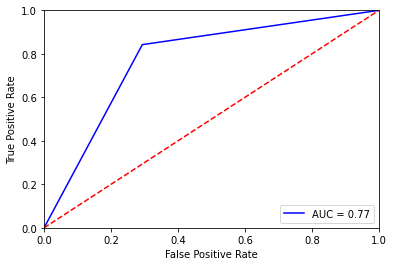

In [44]:
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

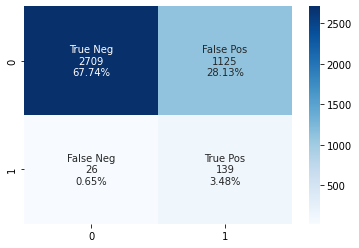

In [ ]:
plot_confusion_matrix(confusion_matrix(test_labels,test_preds))

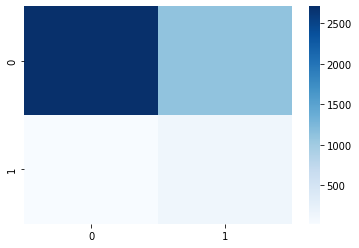

In [45]:
sns.heatmap(confusion_matrix(test_labels,test_preds), cmap='Blues')

In [ ]:
print(classification_report(test_labels,test_preds))

              precision    recall  f1-score   support

           0       0.99      0.71      0.82      3834
           1       0.11      0.84      0.19       165

    accuracy                           0.71      3999
   macro avg       0.55      0.77      0.51      3999
weighted avg       0.95      0.71      0.80      3999



In [46]:
gat_model.eval()
with torch.no_grad():
  test_preds = []
  test_labels = []
  running_loss = 0.0
  steps =0 
  for _, batch in enumerate(tqdm(test_loader)):
    batch.to(device)
    pred = gat_model(batch.x.float(), batch.edge_attr.float(),batch.edge_index, batch.batch)
    # print(batch.y)
    loss = gat_loss_fn(torch.squeeze(pred), batch.y.float())
    test_preds.append(np.rint(torch.sigmoid(pred).cpu().detach().numpy()))
    test_labels.append(batch.y.cpu().detach().numpy())
    running_loss += loss.item()
    steps+=1
  test_preds = np.concatenate(test_preds).ravel()
  test_labels = np.concatenate(test_labels).ravel()
  acc= accuracy_score(test_labels, test_preds)
  pr, tpr, threshold = metrics.roc_curve(test_labels, test_preds)
  roc_auc = metrics.auc(fpr, tpr)
  print(f'\nTest Loss : {running_loss/steps} \n Test Accuracy : {acc}')

100%|██████████| 16/16 [01:40<00:00,  6.26s/it]


Test Loss : 0.276475359685719 
 Test Accuracy : 0.9154788697174293


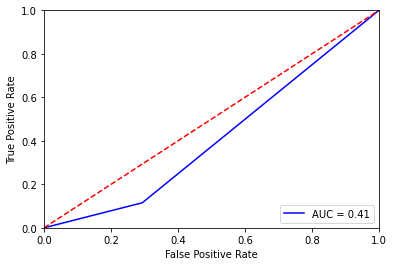

In [33]:
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

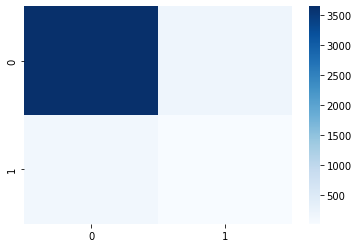

In [47]:
sns.heatmap(confusion_matrix(test_labels,test_preds), cmap='Blues')

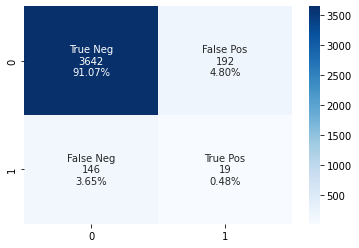

In [ ]:
plot_confusion_matrix(confusion_matrix(test_labels,test_preds))

In [ ]:
print(classification_report(test_labels,test_preds))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      3834
           1       0.09      0.12      0.10       165

    accuracy                           0.92      3999
   macro avg       0.53      0.53      0.53      3999
weighted avg       0.93      0.92      0.92      3999



In [36]:
import math
def sigmoid(x):
  return 1/ (1+math.exp(-x))

In [48]:
with torch.no_grad():
  test_preds = []
  test_labels = []
  for _, batch in enumerate(tqdm(test_loader)):
    batch.to(device)
    # get predictions from gcn
    gcn_preds = gcn_model(batch.x.float(),batch.edge_index, batch.batch)
    gcn_transformed = []
    for pred in gcn_preds:
      if(pred[1] > pred[0]):
        gcn_transformed.append(sigmoid(pred[1]))
      else:
        gcn_transformed.append(1-sigmoid(pred[0]))
    gcn_transformed = np.array(gcn_transformed)
    gcn_transformed = gcn_transformed.reshape(gcn_transformed.shape[0],1) # expand dims to match gat_pred

    # get predictions from gat 
    gat_pred = gat_model(batch.x.float(), batch.edge_attr.float(),batch.edge_index, batch.batch)
    gat_pred = torch.sigmoid(gat_pred.cpu().detach()).numpy()
    
    # ensemble 
    test_preds.append(np.rint((gat_pred + gcn_transformed) /2 ) )
    test_labels.append(batch.y.cpu().detach().numpy())
  test_preds = np.concatenate(test_preds).ravel()
  test_labels = np.concatenate(test_labels).ravel()
  acc= accuracy_score(test_labels, test_preds)
  pr, tpr, threshold = metrics.roc_curve(test_labels, test_preds)
  roc_auc = metrics.auc(fpr, tpr)
  print(f'\n Ensemble Test Accuracy : {acc}')


100%|██████████| 16/16 [01:40<00:00,  6.26s/it]


 Ensemble Test Accuracy : 0.8614653663415854


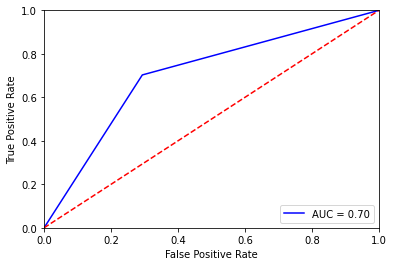

In [42]:
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

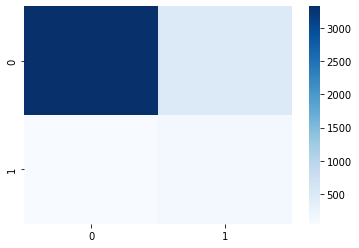

In [49]:
sns.heatmap(confusion_matrix(test_labels,test_preds), cmap='Blues')

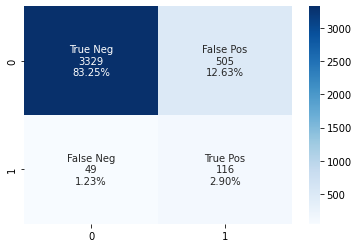

In [ ]:
plot_confusion_matrix(confusion_matrix(test_labels,test_preds))

In [ ]:
print(classification_report(test_labels,test_preds))

              precision    recall  f1-score   support

           0       0.99      0.87      0.92      3834
           1       0.19      0.70      0.30       165

    accuracy                           0.86      3999
   macro avg       0.59      0.79      0.61      3999
weighted avg       0.95      0.86      0.90      3999



In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# GCN 
losses = [0.258, 0.229, 0.205, 0.182, 0.170]
accuracies = [0.541, 0.619, 0.682, 0.732, 0.760]

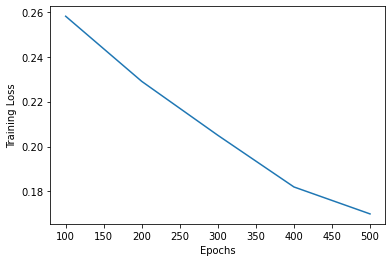

In [ ]:
plt.plot(range(100,600,100),losses)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.show()

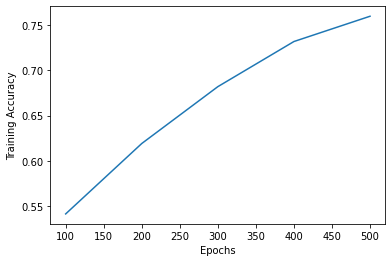

In [ ]:
plt.plot(range(100,600,100),accuracies)
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.show()

In [ ]:
# GAT
losses = [0.819,0.806, 0.797, 0.790, 0.789, 0.783, 0.777, 0.773, 0.767, 0.762,
          
]
accs = [0.578,0.616,0.635,0.647, 0.649,0.657, 0.666, 0.673, 0.680,  0.687,  ]